In [3]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

df = pd.read_csv("../data/processed/cleaned_fake_news.csv")
X = df['content'].fillna("")
y = df['label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
tfidf = joblib.load("../models/tfidf_vectorizer.pkl")
X_test_tfidf = tfidf.transform(X_test)

log_reg = joblib.load("../models/logistic_regression.pkl")
nb = joblib.load("../models/naive_bayes.pkl")
rf = joblib.load("../models/random_forest.pkl")

ml_models = {
    "Logistic Regression": log_reg,
    "Naive Bayes": nb,
    "Random Forest": rf
}

In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load tokenizer
tokenizer = joblib.load("../models/tokenizer.pkl")

# Convert test set into padded sequences
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=300, padding="post")

# Load trained LSTM model
lstm_model = load_model("../models/lstm_model.h5")


In [6]:
# --- ML Models ---
for name, model in ml_models.items():
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append([name, acc, prec, rec, f1])

# --- LSTM Model ---
y_pred_prob = lstm_model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
results.append(["LSTM", acc, prec, rec, f1])

281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step


In [7]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision (Fake)", "Recall (Fake)", "F1 (Fake)"])
print(results_df)

                 Model  Accuracy  Precision (Fake)  Recall (Fake)  F1 (Fake)
0  Logistic Regression  0.987862          0.989959       0.986797   0.988376
1          Naive Bayes  0.928174          0.930683       0.932070   0.931376
2        Random Forest  0.996771          0.996595       0.997232   0.996913
3                 LSTM  0.976949          0.987405       0.968271   0.977744
4  Logistic Regression  0.987862          0.989959       0.986797   0.988376
5          Naive Bayes  0.928174          0.930683       0.932070   0.931376
6        Random Forest  0.996771          0.996595       0.997232   0.996913
7                 LSTM  0.976949          0.987405       0.968271   0.977744


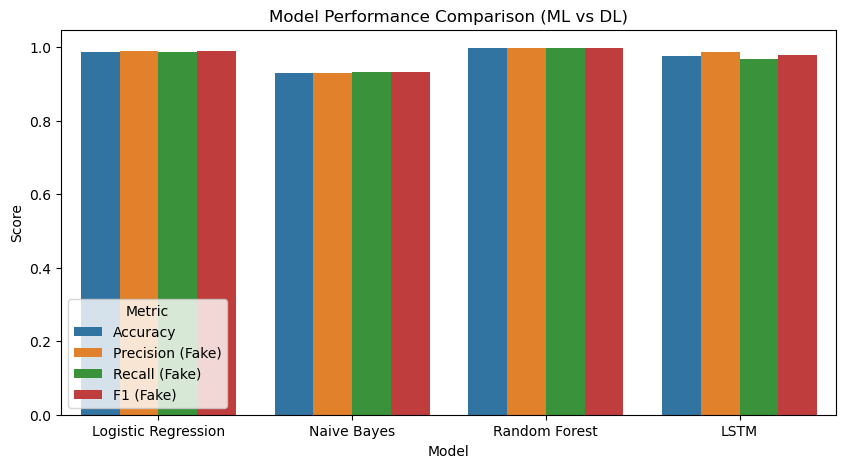

In [8]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=results_df.melt("Model", var_name="Metric", value_name="Score"),
    x="Model", y="Score", hue="Metric"
)
plt.title("Model Performance Comparison (ML vs DL)")
plt.show()

In [9]:
print("\n=== LSTM Classification Report ===")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


=== LSTM Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4284
           1       0.99      0.97      0.98      4696

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980

Confusion Matrix:
 [[4226   58]
 [ 149 4547]]


In [16]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load saved model
bilstm_model = load_model("../models/bilstm_fake_news.h5")

# Evaluate on test data
y_pred_prob = bilstm_model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)

results.append(["BiLSTM", acc, prec, rec, f1])


281/281 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step
Accuracy: 0.988641425389755
Precision: 0.992284612087441
Recall: 0.9859454855195912
F1 Score: 0.989104892117069


In [19]:
results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision (Fake)","Recall (Fake)","F1 (Fake)"])
results_df = results_df.drop_duplicates()
print(results_df)

                 Model  Accuracy  Precision (Fake)  Recall (Fake)  F1 (Fake)
0  Logistic Regression  0.987862          0.989959       0.986797   0.988376
1          Naive Bayes  0.928174          0.930683       0.932070   0.931376
2        Random Forest  0.996771          0.996595       0.997232   0.996913
3                 LSTM  0.976949          0.987405       0.968271   0.977744
8               BiLSTM  0.988641          0.992285       0.985945   0.989105


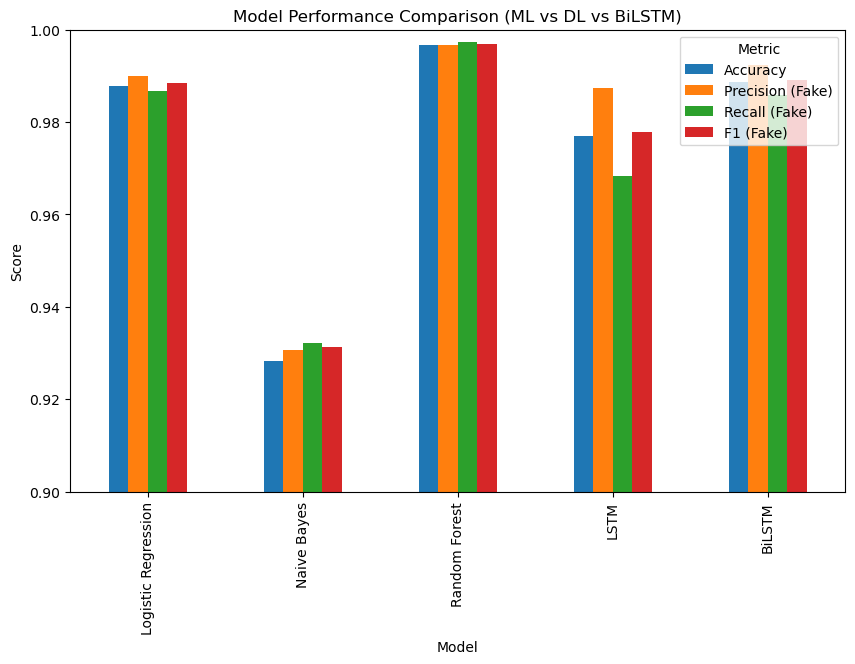

In [20]:
import matplotlib.pyplot as plt

results_df.set_index("Model")[["Accuracy", "Precision (Fake)", "Recall (Fake)", "F1 (Fake)"]].plot(
    kind="bar", figsize=(10,6)
)
plt.title("Model Performance Comparison (ML vs DL vs BiLSTM)")
plt.ylabel("Score")
plt.ylim(0.9, 1.0)   # zoom into high-performance range
plt.legend(title="Metric")
plt.show()

281/281 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step


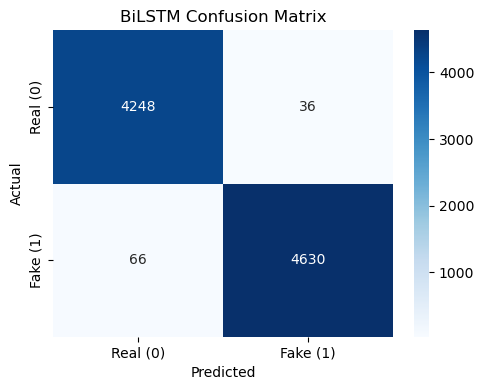


=== BiLSTM Classification Report ===
              precision    recall  f1-score   support

           0      0.985     0.992     0.988      4284
           1      0.992     0.986     0.989      4696

    accuracy                          0.989      8980
   macro avg      0.988     0.989     0.989      8980
weighted avg      0.989     0.989     0.989      8980



In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- BiLSTM predictions ---
bilstm_prob = bilstm_model.predict(X_test_pad)   # ✅ use bilstm_model, not model
bilstm_pred = (bilstm_prob > 0.5).astype("int32")

# --- Confusion matrix ---
cm_bilstm = confusion_matrix(y_test, bilstm_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Real (0)", "Fake (1)"],
            yticklabels=["Real (0)", "Fake (1)"])
plt.title("BiLSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- Classification report ---
print("\n=== BiLSTM Classification Report ===")
print(classification_report(y_test, bilstm_pred, digits=3))


281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step


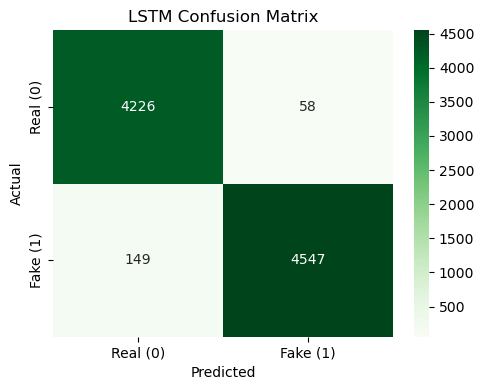


=== LSTM Classification Report ===
              precision    recall  f1-score   support

           0      0.966     0.986     0.976      4284
           1      0.987     0.968     0.978      4696

    accuracy                          0.977      8980
   macro avg      0.977     0.977     0.977      8980
weighted avg      0.977     0.977     0.977      8980



In [23]:
# If you also have `lstm_model`
lstm_prob = lstm_model.predict(X_test_pad)
lstm_pred = (lstm_prob > 0.5).astype("int32")

cm_lstm = confusion_matrix(y_test, lstm_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap="Greens",
            xticklabels=["Real (0)", "Fake (1)"],
            yticklabels=["Real (0)", "Fake (1)"])
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("\n=== LSTM Classification Report ===")
print(classification_report(y_test, lstm_pred, digits=3))


In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrices(y_test, lstm_pred, bilstm_pred, save_path=None):
    """
    Plots LSTM and BiLSTM confusion matrices side by side.
    """
    cm_lstm = confusion_matrix(y_test, lstm_pred)
    cm_bilstm = confusion_matrix(y_test, bilstm_pred)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # LSTM Confusion Matrix
    sns.heatmap(cm_lstm, annot=True, fmt='d', cmap="Greens", ax=axes[0],
                xticklabels=["Real (0)", "Fake (1)"],
                yticklabels=["Real (0)", "Fake (1)"])
    axes[0].set_title("LSTM Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    # BiLSTM Confusion Matrix
    sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap="Blues", ax=axes[1],
                xticklabels=["Real (0)", "Fake (1)"],
                yticklabels=["Real (0)", "Fake (1)"])
    axes[1].set_title("BiLSTM Confusion Matrix")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Confusion matrices saved to {save_path}")
    plt.show()


281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 36s 127ms/step
Confusion matrices saved to ../reports/confusion_matrices.png


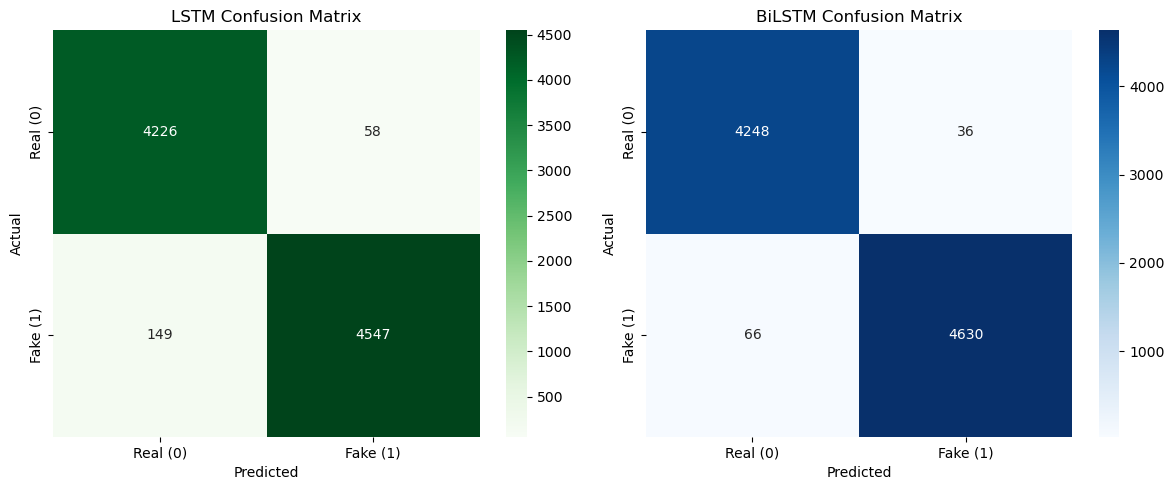

In [25]:
# Get predictions
lstm_prob = lstm_model.predict(X_test_pad)
lstm_pred = (lstm_prob > 0.5).astype("int32")

bilstm_prob = bilstm_model.predict(X_test_pad)   # your BiLSTM model
bilstm_pred = (bilstm_prob > 0.5).astype("int32")

# Plot & Save
plot_confusion_matrices(y_test, lstm_pred, bilstm_pred,
                        save_path="../reports/confusion_matrices.png")


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

# --- LSTM ---
lstm_prec = precision_score(y_test, lstm_pred)
lstm_rec = recall_score(y_test, lstm_pred)
lstm_f1 = f1_score(y_test, lstm_pred)

# --- BiLSTM ---
bilstm_prec = precision_score(y_test, bilstm_pred)
bilstm_rec = recall_score(y_test, bilstm_pred)
bilstm_f1 = f1_score(y_test, bilstm_pred)

# Combine into a DataFrame
import pandas as pd
metrics_df = pd.DataFrame({
    "Model": ["LSTM", "BiLSTM"],
    "Precision": [lstm_prec, bilstm_prec],
    "Recall": [lstm_rec, bilstm_rec],
    "F1-Score": [lstm_f1, bilstm_f1]
})
print(metrics_df)


    Model  Precision    Recall  F1-Score
0    LSTM   0.987405  0.968271  0.977744
1  BiLSTM   0.992285  0.985945  0.989105


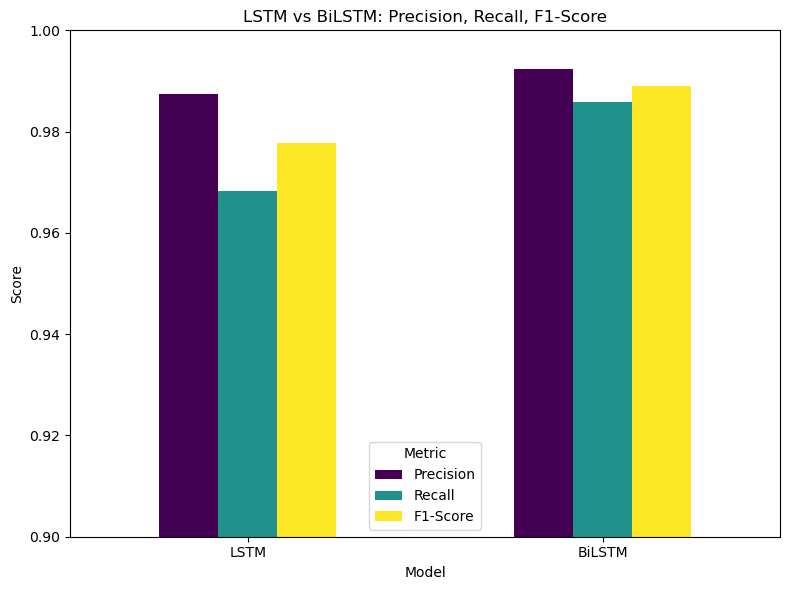

In [27]:
import matplotlib.pyplot as plt

metrics_df.set_index("Model").plot(
    kind="bar", figsize=(8,6), ylim=(0.9,1.0), colormap="viridis"
)

plt.title("LSTM vs BiLSTM: Precision, Recall, F1-Score")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


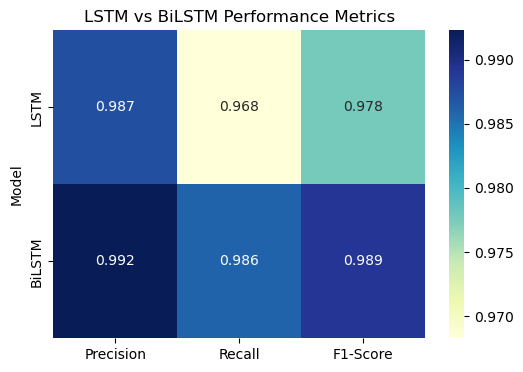

In [28]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(metrics_df.set_index("Model"), annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("LSTM vs BiLSTM Performance Metrics")
plt.show()
